In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
# import seaborn as sns
import pandas as pd


# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
from platform import python_version
print(python_version())

import dill

import geopandas as gpd

0.12.1
0.4.13
3.10.1


In [28]:
import os
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/notebooks/zimbabwe'

In [2]:
args = {"seed": 0,
        # MCMC setup
        "mcmc_run": True,
        "mcmc_save": True,
        "num_warmup": 2000,
        "num_samples": 10000,
        "num_chains": 2,
        "thinning": 1
       }

## Data

In [3]:
data_path = "../../zimbabwe/data/zwe2016phia.geojson"

(63, 31)


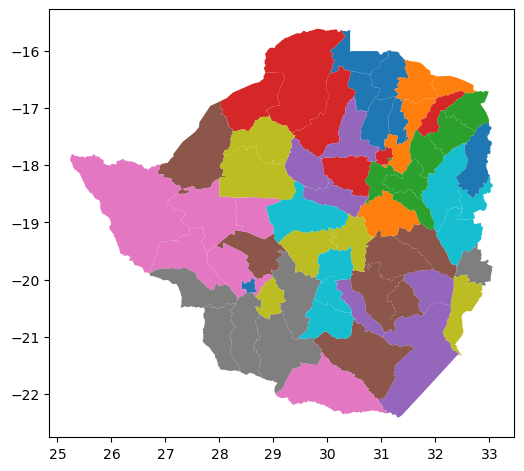

In [4]:
s = gpd.read_file(data_path)
print(s.shape)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
s.plot(column='area_id', ax=ax, legend=False)

In [5]:
s = s[['area_id', 'geometry', 'y', 'n_obs', 'estimate']]
s['y'] = round(s['y']).astype(int)
s['n_obs'] = round(s['n_obs']).astype(int)
s["centroid"] = s["geometry"].centroid
print(np.sum(np.isnan(s['n_obs'])))
print(s.shape)
s.head()

/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0
(63, 6)


/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_85664/2991311570.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  s["centroid"] = s["geometry"].centroid
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,area_id,geometry,y,n_obs,estimate,centroid
0,ZWE_2_1,"MULTIPOLYGON (((28.60837 -20.23077, 28.60534 -...",250,1520,0.164841,POINT (28.55557 -20.12184)
1,ZWE_2_2,"MULTIPOLYGON (((30.99973 -17.99862, 31.00954 -...",44,280,0.155943,POINT (31.06270 -18.01409)
2,ZWE_2_3,"MULTIPOLYGON (((31.13664 -17.92887, 31.13584 -...",148,1243,0.119002,POINT (31.04900 -17.83975)
3,ZWE_2_4,"MULTIPOLYGON (((31.72304 -19.02447, 31.73064 -...",28,265,0.105219,POINT (31.86831 -19.44905)
4,ZWE_2_5,"MULTIPOLYGON (((32.87748 -20.09961, 32.85814 -...",10,118,0.086011,POINT (32.72163 -19.78411)


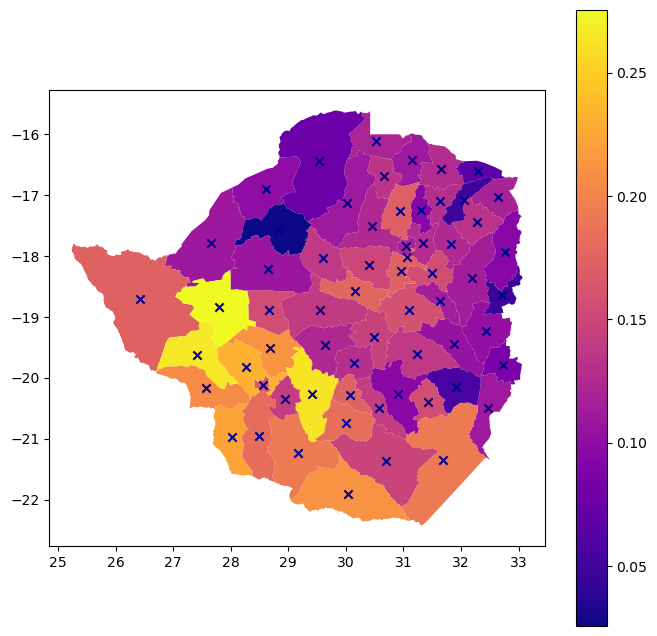

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#divider = make_axes_locatable(ax)
s.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
s["centroid"].plot(ax=ax, color="DarkBlue", marker="x")

## GP priors

In [7]:
# functions implementing GP priors, which are generalisable for any number of dimensions

def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

# Prevalence model - centroids

In [8]:
def prev_model_centroids(x, n_obs=None, length=None, var=1, jitter=1.0e-5, gp_kernel=exp_sq_kernel, y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
    
    if length==None:  
        length = numpyro.sample("length", npdist.Gamma(2,4)) 
    
    k = gp_kernel(x, x, var, length, jitter)
    
    kernel_var = numpyro.sample("kernel_var", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # linear predictor
    lp = b0 + re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [9]:
#temp_centroids = s["geometry"].to_crs("EPSG:32735").centroid
temp_centroids = s["geometry"].centroid
centroids = gpd.GeoDataFrame()
centroids["x"] = temp_centroids.geometry.apply(lambda x: x.x)
centroids["y"] = temp_centroids.geometry.apply(lambda x: x.y)
x_coords = jnp.array(centroids["x"])
y_coords = jnp.array(centroids["y"])
coords = jnp.dstack((x_coords, y_coords))[0]
coords.shape
coords[0:10,:]

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_85664/258168673.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = s["geometry"].centroid


Array([[ 28.555567, -20.121845],
       [ 31.062702, -18.014091],
       [ 31.048996, -17.839746],
       [ 31.868307, -19.44905 ],
       [ 32.721634, -19.784111],
       [ 32.474644, -20.495062],
       [ 32.182587, -18.362677],
       [ 32.43056 , -19.223494],
       [ 32.708965, -18.639462],
       [ 32.75779 , -17.937792]], dtype=float32)

## Prior predictive

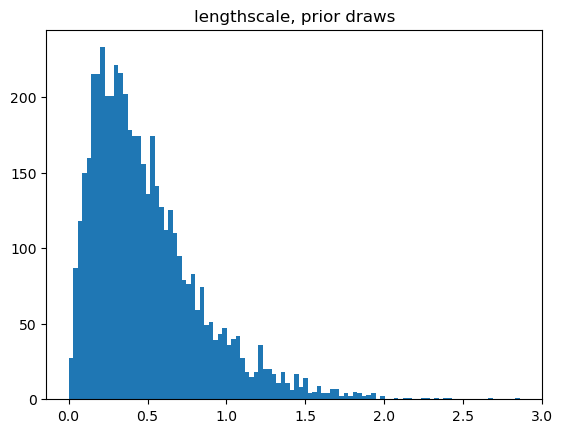

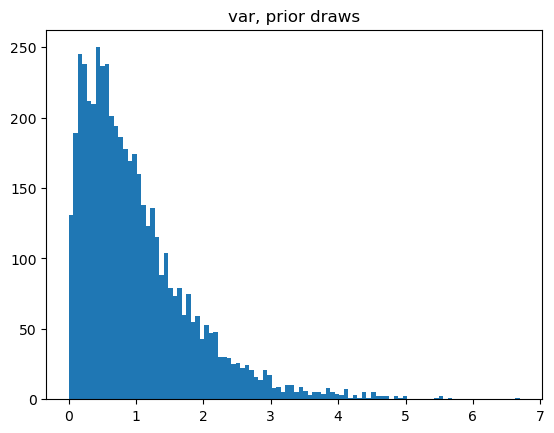

In [10]:
rng_key, rng_key_ = random.split(random.PRNGKey(4))
gp_predictive = Predictive(prev_model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=jnp.array(coords), n_obs = jnp.array(s.n_obs))

ls_prior_draws = gp_preds['length']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['kernel_var']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

Text(0.5, 1, 'Prior max')

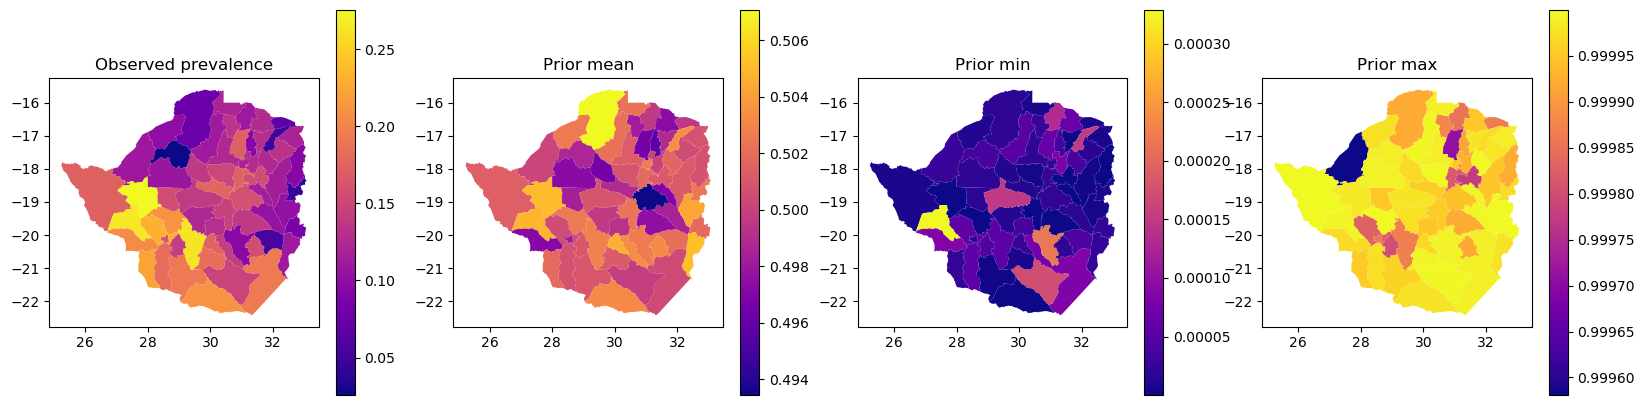

In [11]:
prior_theta = gp_preds['theta']

prior_theta_mean = prior_theta.mean(axis=0)
prior_theta_min = prior_theta.min(axis=0)
prior_theta_max = prior_theta.max(axis=0)

s['prior_theta_mean'] = prior_theta_mean
s['prior_theta_min'] = prior_theta_min
s['prior_theta_max'] = prior_theta_max

theta_observed = s['estimate']

_max = np.max([theta_observed, prior_theta_max])
_min = np.min([theta_observed, prior_theta_min])

fig, ax = plt.subplots(1, 4, figsize=(20,5))

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_mean", ax=ax[1], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_min", ax=ax[2], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_max", ax=ax[3], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)

ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Prior mean')
ax[2].set_title( 'Prior min')
ax[3].set_title( 'Prior max')

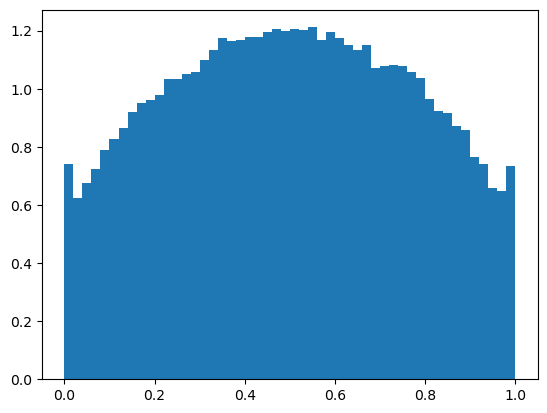

In [12]:
prior_theta_long = prior_theta.reshape(-1)
plt.hist(prior_theta_long, density=True, bins=50)
plt.show()

## Inference

In [19]:
rng_num = 4

mcmc_fits_path = "/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/mcmc_fits/"

mcmc_save_name = mcmc_fits_path + 'zimbabwe_unnorm_rbf_' + str(args['num_samples']) + '_' + str(rng_num) + '.pkl'

print(mcmc_save_name)

/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/mcmc_fits/zimbabwe_unnorm_rbf_10000_4.pkl


In [16]:
if args["mcmc_run"] == True:
    rng_key, rng_key_predict = random.split(random.PRNGKey(rng_num))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_centroids)
    mcmc_gp = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_samples'], num_chains=args["num_chains"])
    mcmc_gp.run(rng_key, x=jnp.array(coords), n_obs = jnp.array(s.n_obs), y = jnp.array(s.y))
    t_elapsed = time.time() - start
    
    if args["mcmc_save"] == True:
        with open(mcmc_save_name, 'wb') as f:
            dill.dump(mcmc_gp, f)
        print("saved MCMC results")    

else:
    with open(mcmc_save_name, 'rb') as f:
        mcmc_gp = dill.load(f)
    print("loaded MCMC results")    
        

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

saved MCMC results


In [20]:
mcmc_save_name

with open(mcmc_save_name, 'wb') as f:
    dill.dump(mcmc_gp, f)
print("saved MCMC results") 

saved MCMC results


In [21]:
prev_samples_gp = mcmc_gp.get_samples()
mcmc_gp.print_summary(exclude_deterministic=False)
mcmc_gp_samples = mcmc_gp.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          b0     -1.80      0.15     -1.80     -2.04     -1.56    794.89      1.00
  kernel_var      0.39      0.10      0.37      0.25      0.52    398.57      1.00
      length      0.99      0.26      0.95      0.60      1.39    137.48      1.00
       re[0]      0.24      0.17      0.24     -0.01      0.52    865.66      1.00
       re[1]     -0.02      0.16     -0.02     -0.27      0.24    896.43      1.00
       re[2]     -0.05      0.16     -0.05     -0.32      0.19    852.93      1.00
       re[3]     -0.30      0.19     -0.29     -0.60      0.01   1192.11      1.00
       re[4]     -0.47      0.22     -0.46     -0.83     -0.13   1487.10      1.00
       re[5]     -0.26      0.20     -0.25     -0.57      0.07   1407.70      1.00
       re[6]     -0.27      0.18     -0.26     -0.57      0.02   1104.30      1.00
       re[7]     -0.44      0.19     -0.44     -0.74     -0.13   1182.28      1.00
   

In [22]:
if args["mcmc_run"] == True:
    print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = np.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 1192 s
Average ESS for all REs : 1154


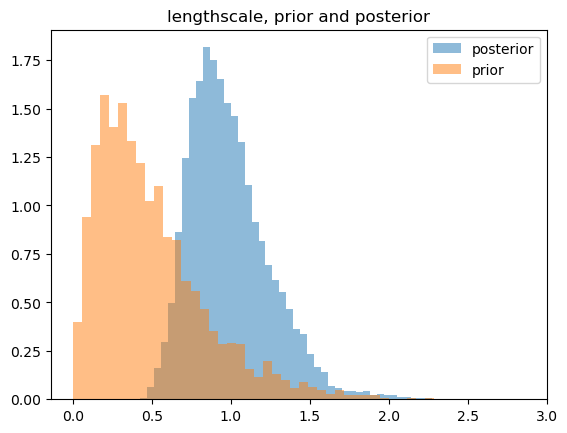

In [23]:
c_samps_gp = mcmc_gp_samples['length']
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('lengthscale, prior and posterior')
plt.legend()

(0, 3)

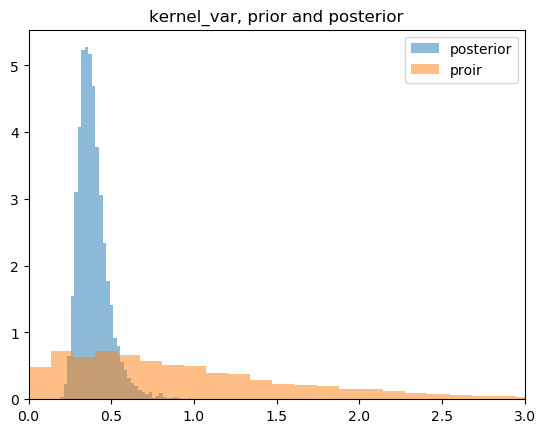

In [24]:
var_samps_gp = mcmc_gp_samples['kernel_var']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'proir', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

Text(0.5, 1, 'Estimated prevalence (GP centroids)')

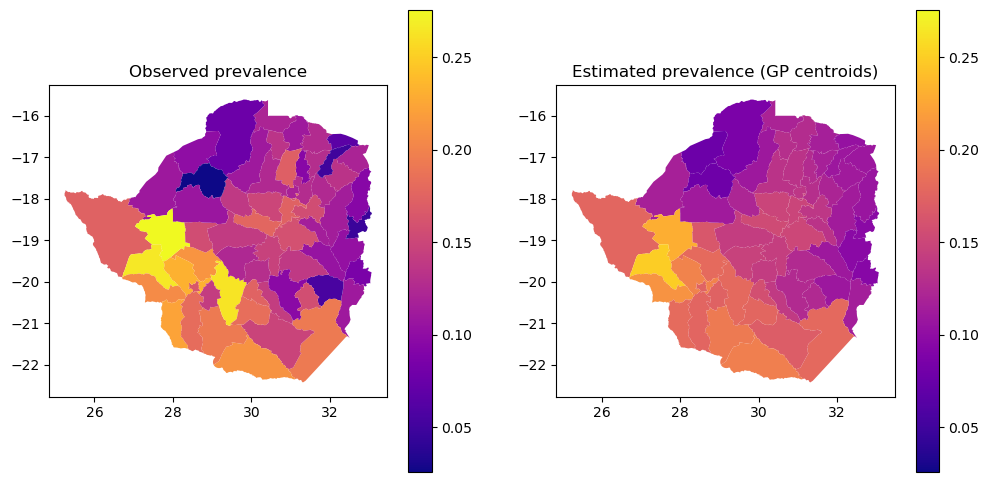

In [25]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_centroids, prev_samples_gp)(random.PRNGKey(1), x=jnp.array(coords), n_obs = jnp.array(s.n_obs))


theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp

theta_observed = s['estimate']
theta_estimated_gp = s['theta_gp']

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (GP centroids)')

AttributeError: module 'matplotlib.pyplot' has no attribute 'axline'

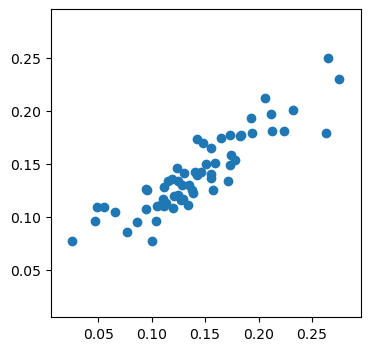

In [26]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(theta_observed, theta_estimated_gp)
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("observed theta")
plt.ylabel("CAR estimated theta")

In [27]:
#fname = 'mcmc/Zimbabwe_gp' + '_niter' + str(args["num_samples"] + args["num_warmup"]) + '.pkl'
#print(fname)

#import dill
#with open(fname, 'wb') as f:
#    dill.dump(mcmc_gp, f)

#with open(fname, 'rb') as f:
#    mcmc = dill.load(f)

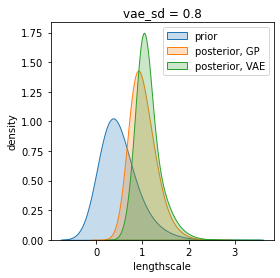

In [157]:
bw = 4
sns.kdeplot(ls_prior_draws, bw_adjust= bw, shade = True, label='prior')
sns.kdeplot(c_samps_gp, bw_adjust= bw, shade = True, label='posterior, GP')
sns.kdeplot(c_samps_vae, bw_adjust= bw, shade = True, label='posterior, VAE')
plt.xlabel('lengthscale')
plt.ylabel('density')
plt.title('vae_sd = ' + str(config["vae_sd"]))
plt.legend()

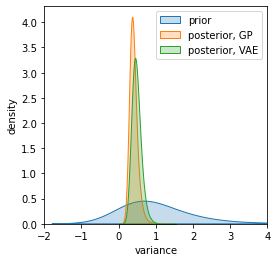

In [158]:
var_samps_gp = mcmc_gp_samples['kernel_var']
var_samps_vae = mcmc_vae_samples['kernel_var']
#plt.hist(var_samps_vae, density=True, label = 'posterior samples, VAE', bins=40, alpha=0.5)
#plt.hist(var_samps_gp, density=True, label = 'posterior samples, GP', bins=40, alpha=0.5)


bw = 4
sns.kdeplot(kernel_var_prior, bw_adjust= bw, shade = True, label='prior')
sns.kdeplot(var_samps_gp, bw_adjust= bw, shade = True, label='posterior, GP')
sns.kdeplot(var_samps_vae, bw_adjust= bw, shade = True, label='posterior, VAE')
plt.xlabel('variance')
plt.ylabel('density')
plt.xlim(-2,4)
plt.legend()

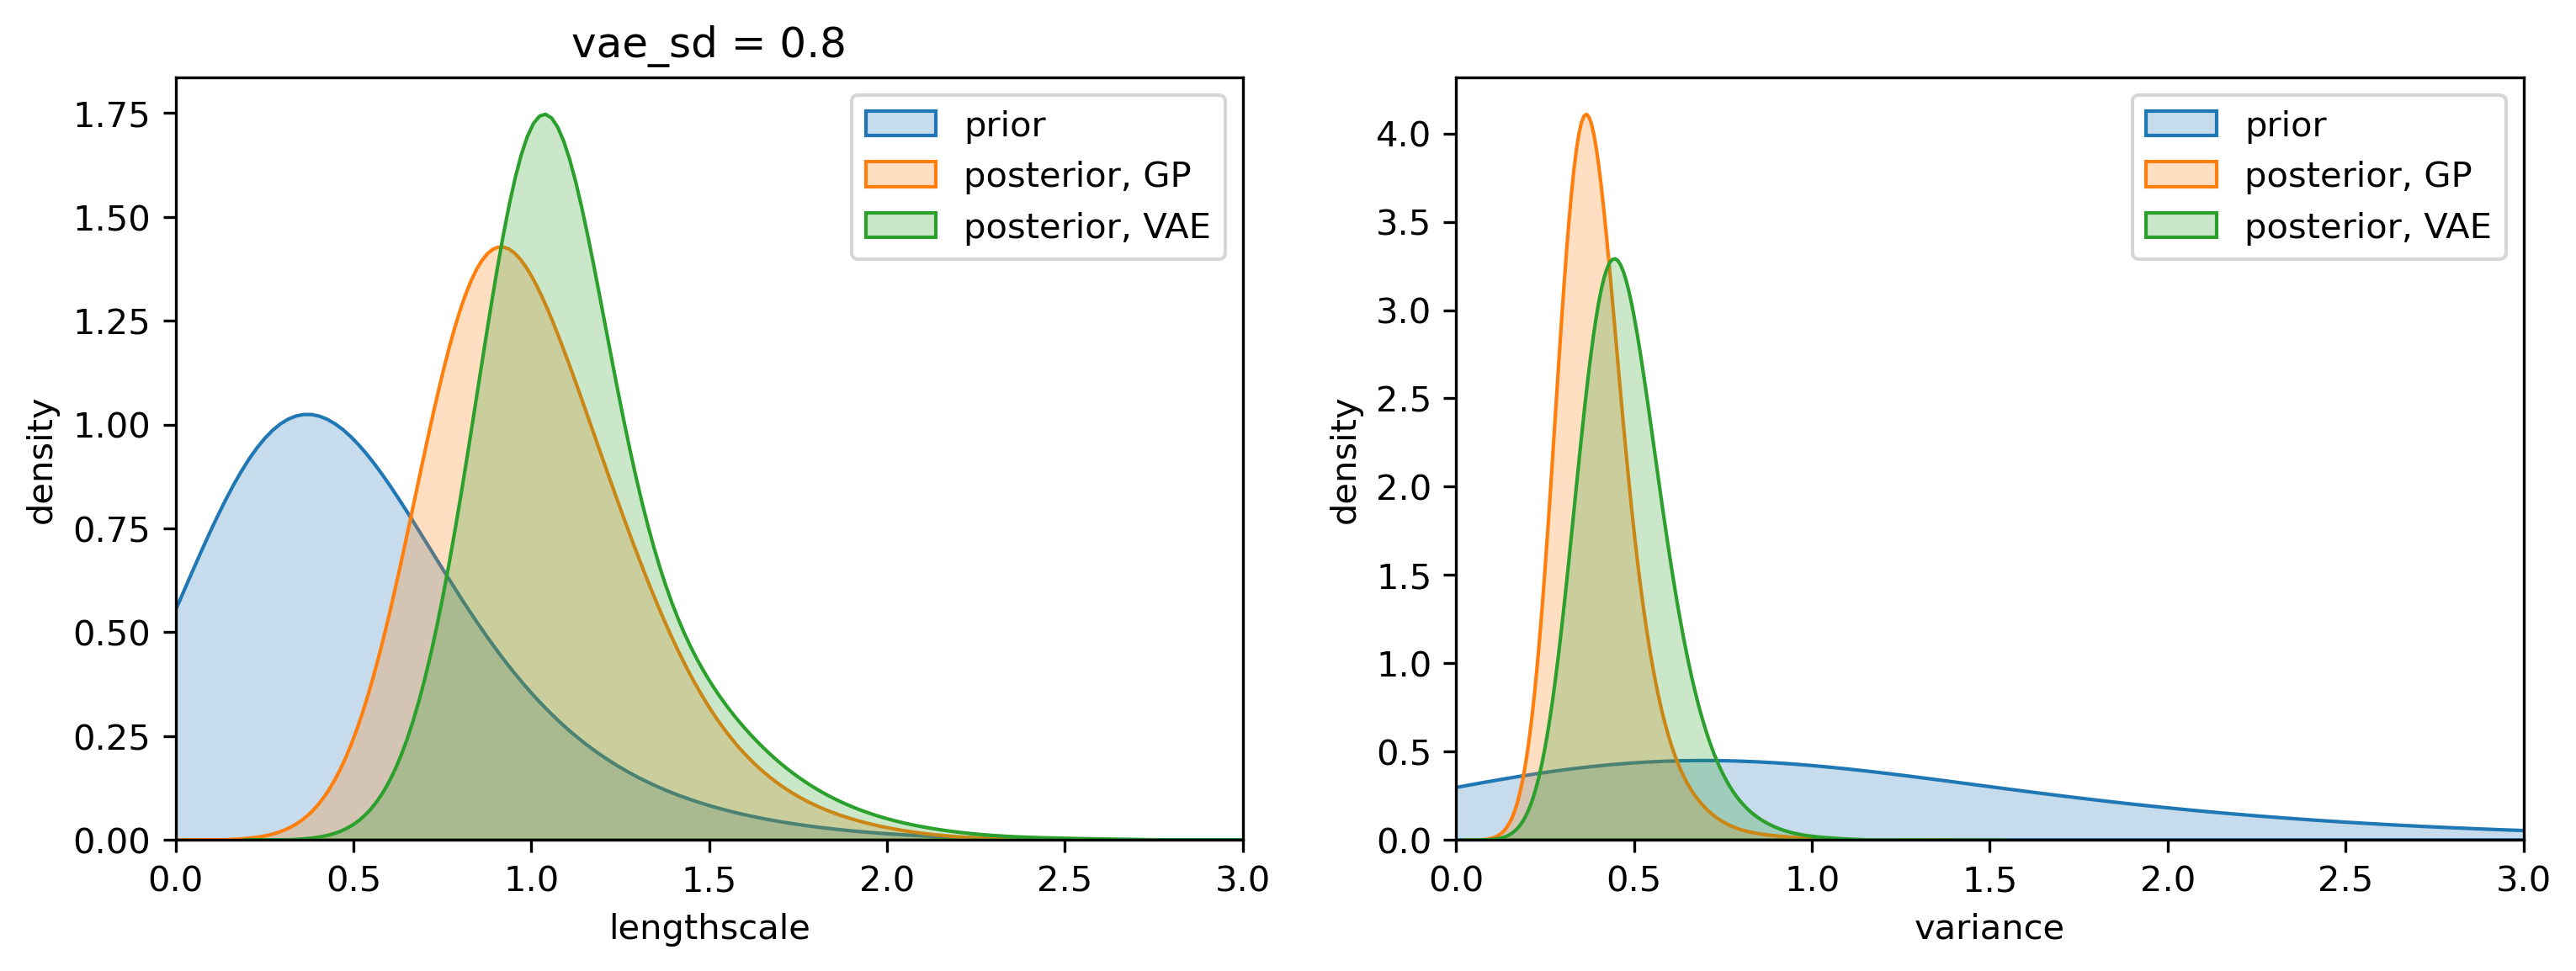

In [185]:
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,6))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

bw_ls = 4
sns.kdeplot(ls_prior_draws, bw_adjust= bw_ls, shade = True, label='prior', ax=axs[0])
sns.kdeplot(c_samps_gp, bw_adjust= bw_ls, shade = True, label='posterior, GP', ax=axs[0])
sns.kdeplot(c_samps_vae, bw_adjust= bw_ls, shade = True, label='posterior, VAE', ax=axs[0])
axs[0].set_xlabel('lengthscale')
axs[0].set_ylabel('density')
axs[0].set_title('vae_sd = ' + str(config["vae_sd"]))
axs[0].set_xlim(0,3)
axs[0].legend()

bw_var = 4
sns.kdeplot(kernel_var_prior, bw_adjust= bw_var, shade = True, label='prior', ax=axs[1])
sns.kdeplot(var_samps_gp, bw_adjust= bw_var, shade = True, label='posterior, GP', ax=axs[1])
sns.kdeplot(var_samps_vae, bw_adjust= bw_var, shade = True, label='posterior, VAE', ax=axs[1])
axs[1].set_xlabel('variance')
axs[1].set_ylabel('density')
axs[1].set_xlim(0,3)
#axs[1].set_title('vae_sd = ' + str(config["vae_sd"]))
axs[1].legend()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/Zimbabwe_estimates_vaeSd{}.pdf'.format(config["vae_sd"]))

In [163]:
import arviz as az

array([[<AxesSubplot: title={'center': 'c'}>,
        <AxesSubplot: title={'center': 'c'}>]], dtype=object)

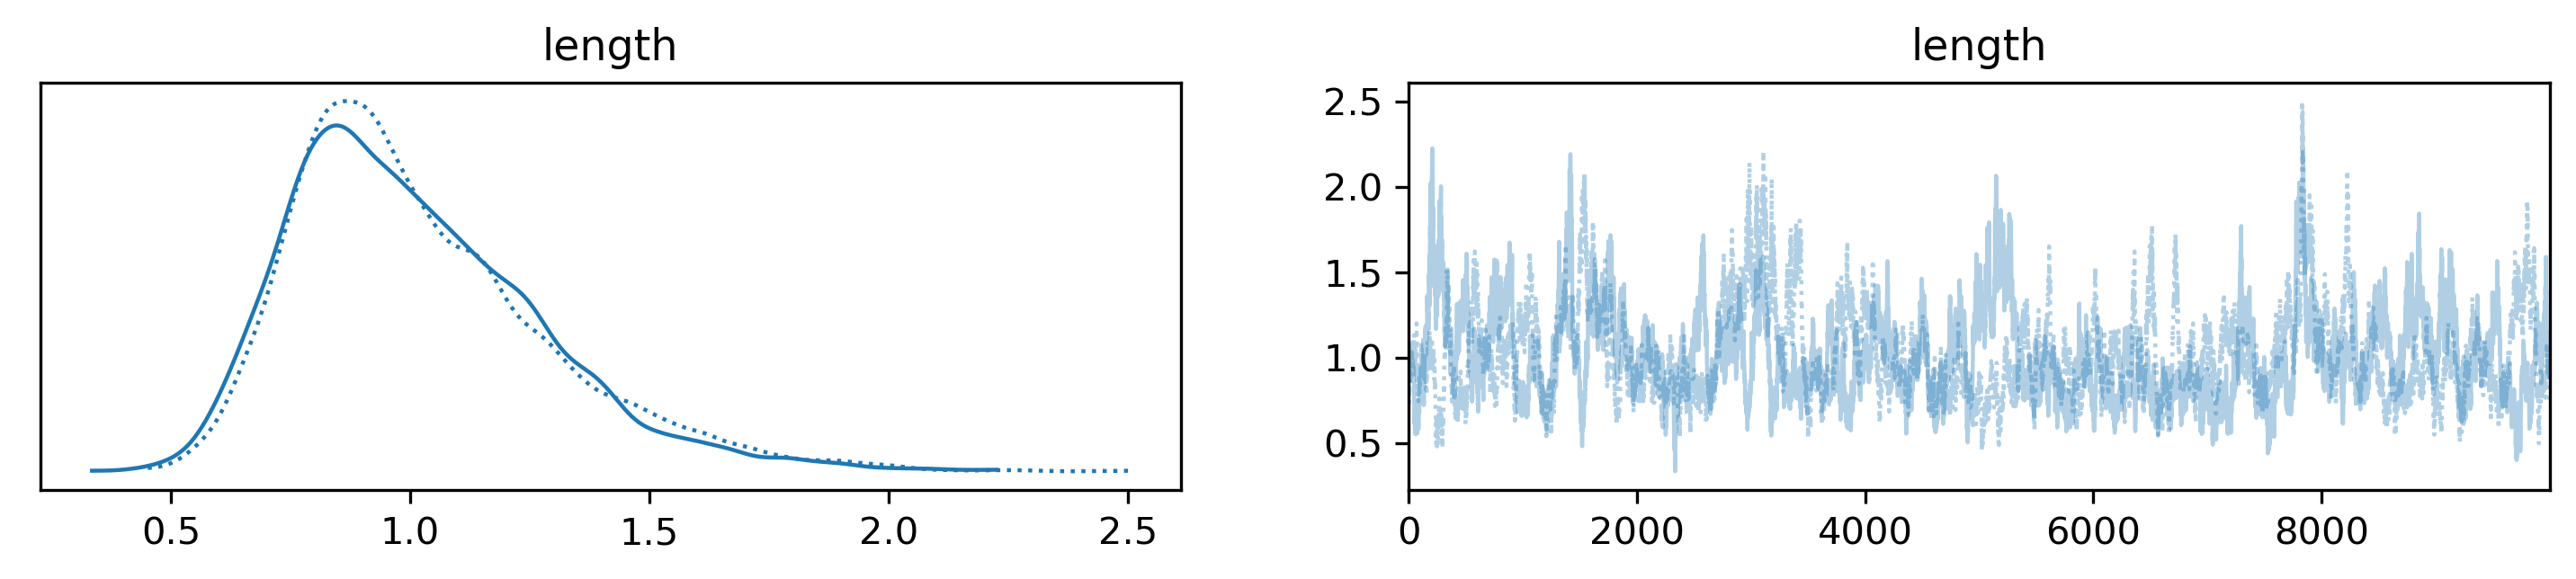

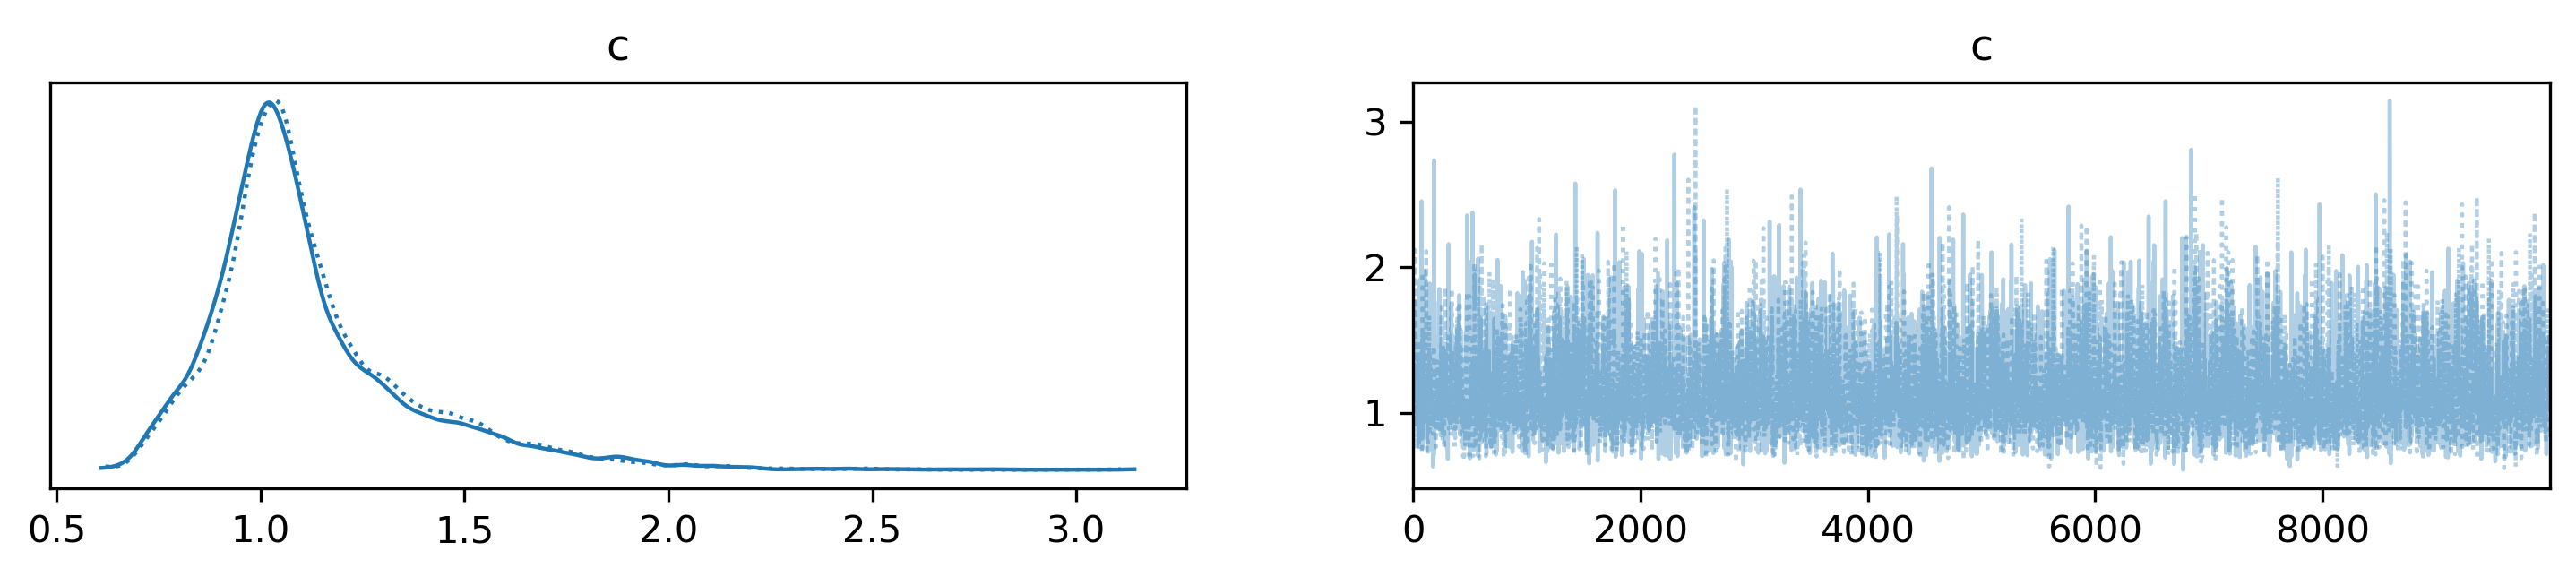

In [164]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)
prev_samples_gp_az = az.from_numpyro(mcmc_gp)
#az.plot_trace(prev_samples_car_az,  var_names=("CAR 1"))
#az.plot_trace(prev_samples_vae_az,  var_names=("VAE-CAR 1"))
az.plot_trace(prev_samples_gp_az,  var_names=("length"))
az.plot_trace(prev_samples_vae_az,  var_names=("c"))

Text(0.5, 1.0, 'Estimated prevalence (VAE)')

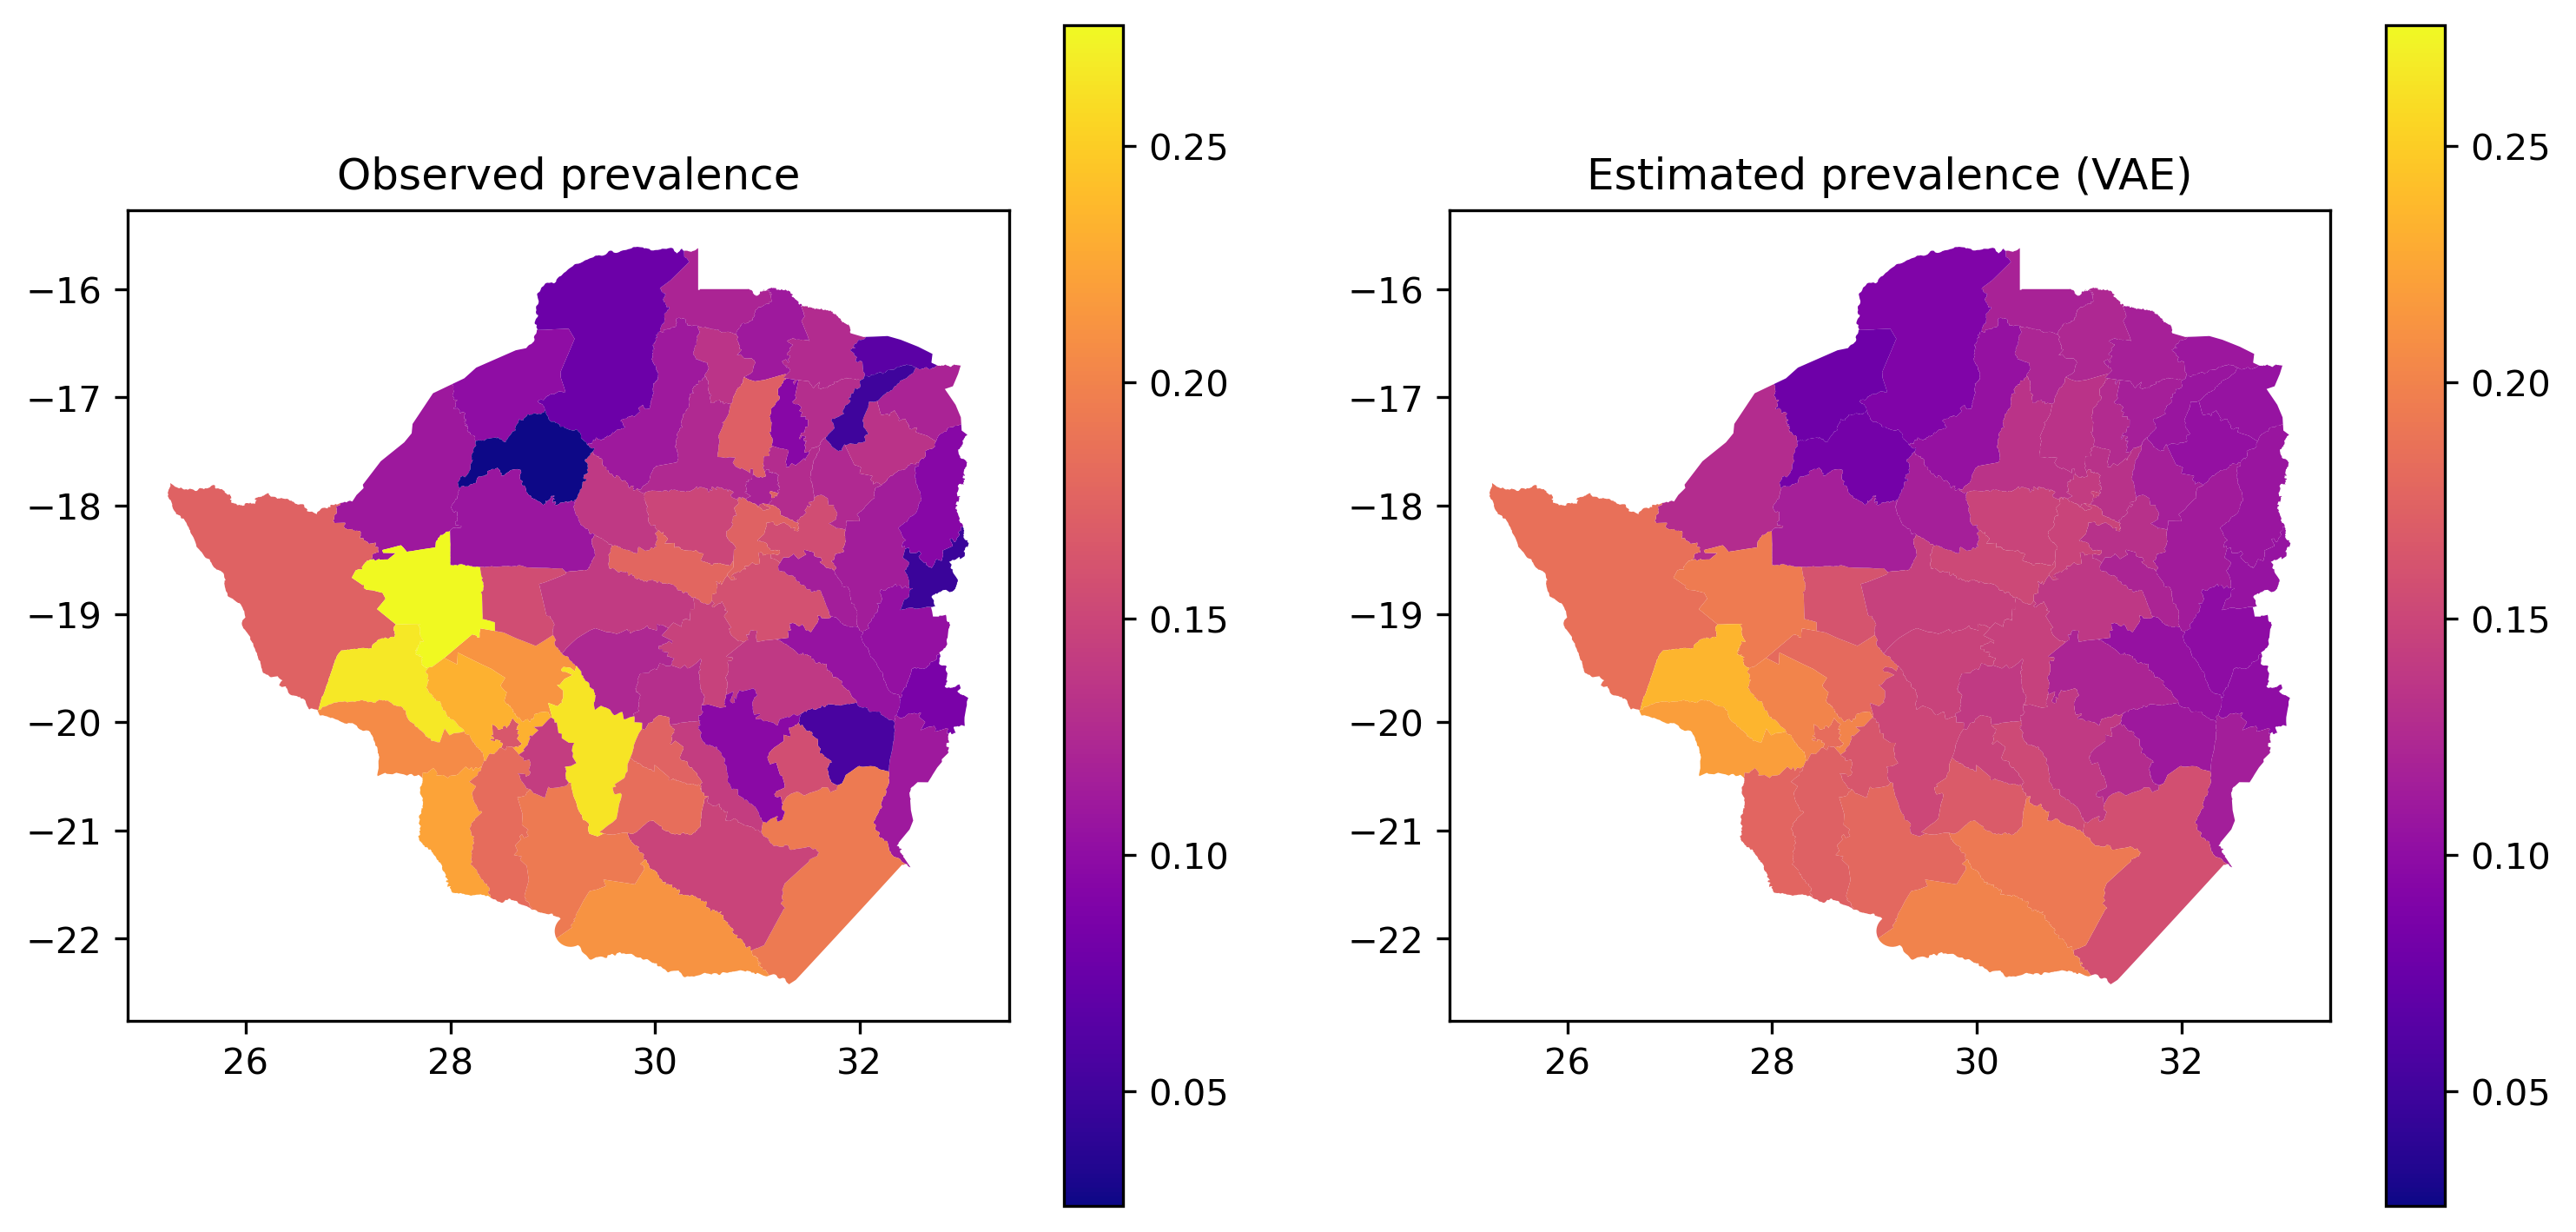

In [165]:
# posterior predictive
prev_posterior_predictive_vae = Predictive(prev_model_VAE, prev_samples_vae)(random.PRNGKey(1), n_obs = jnp.array(s.n_obs))

theta_samps_vae = prev_posterior_predictive_vae['theta']
theta_mean_vae = theta_samps_vae.mean(axis=0)
bci_vae_25 = np.quantile(theta_samps_vae, 0.25, axis=0)
bci_vae_75 = np.quantile(theta_samps_vae, 0.75, axis=0)

s['theta_vae'] = theta_mean_vae

theta_observed = s['estimate']
theta_estimated_vae = s['theta_vae']

_max = np.max([theta_observed, theta_estimated_vae])
_min = np.min([theta_observed, theta_estimated_vae])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (VAE)')

Text(0, 0.5, 'VAE estimated theta')

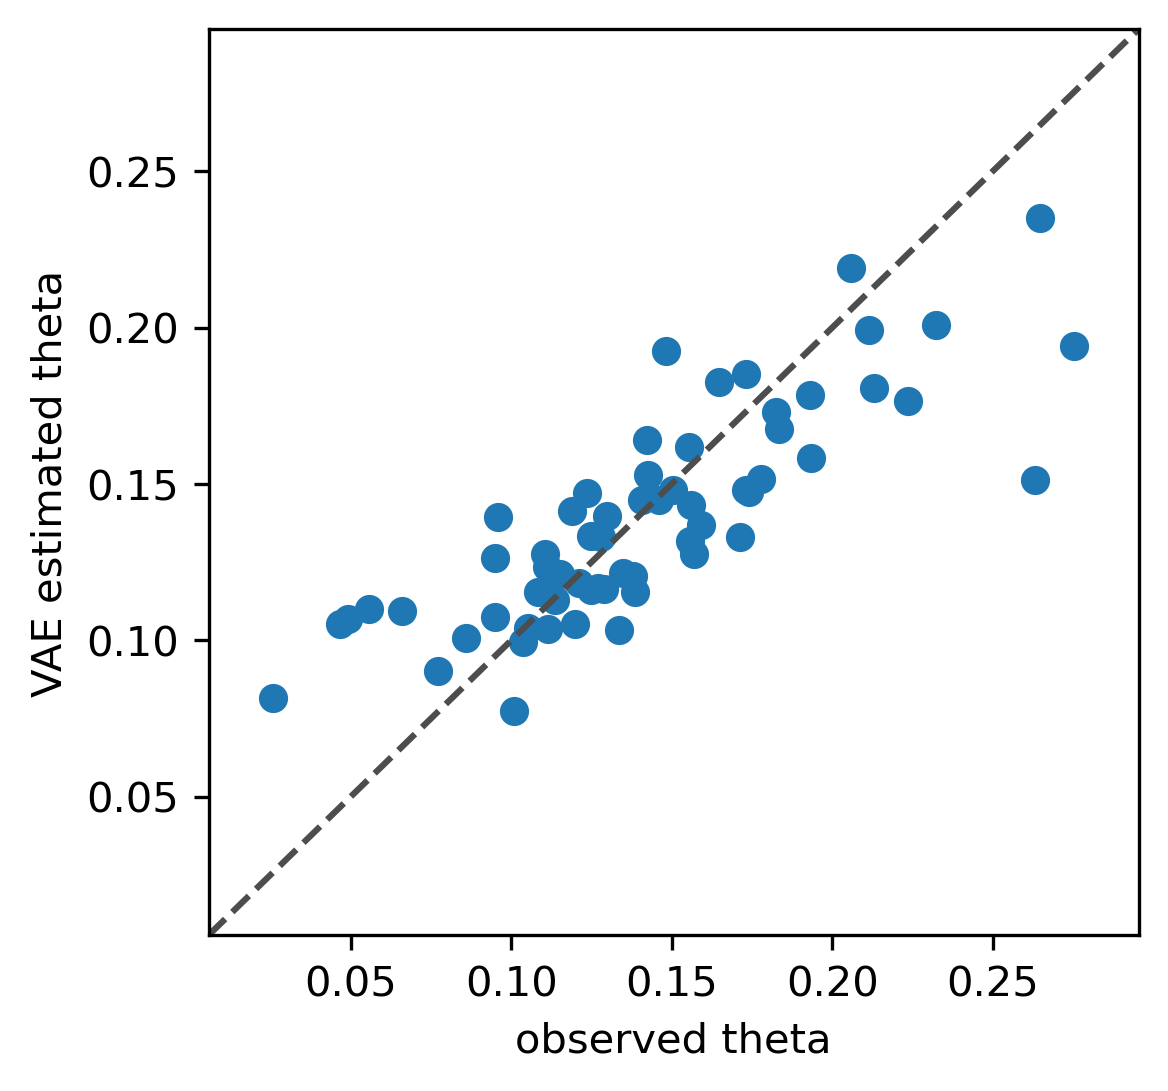

In [166]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(theta_observed, theta_estimated_vae)
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("observed theta")
plt.ylabel("VAE estimated theta")

In [167]:
vaecar0_samps = prev_posterior_predictive_vae['VAE-CAR 1']
n_samps = vaecar0_samps.shape[0]
car0_samps = prev_posterior_predictive['CAR 1']
n_samps = car0_samps.shape[0]

import pandas as pd
df_plt = pd.DataFrame({'VAE-CAR': vaecar0_samps, 'CAR': car0_samps})
df_plt.head()
df_plt.plot(lw = 0.6, alpha=0.9, figsize=(10, 5))
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Parameter estimate")
#plt.show()

KeyError: 'VAE-CAR 1'

In [168]:
s.columns

Index(['area_id', 'geometry', 'y', 'n_obs', 'estimate', 'centroid',
       'prior_theta_mean', 'prior_theta_min', 'prior_theta_max', 'theta_gp',
       'theta_vae'],
      dtype='object')

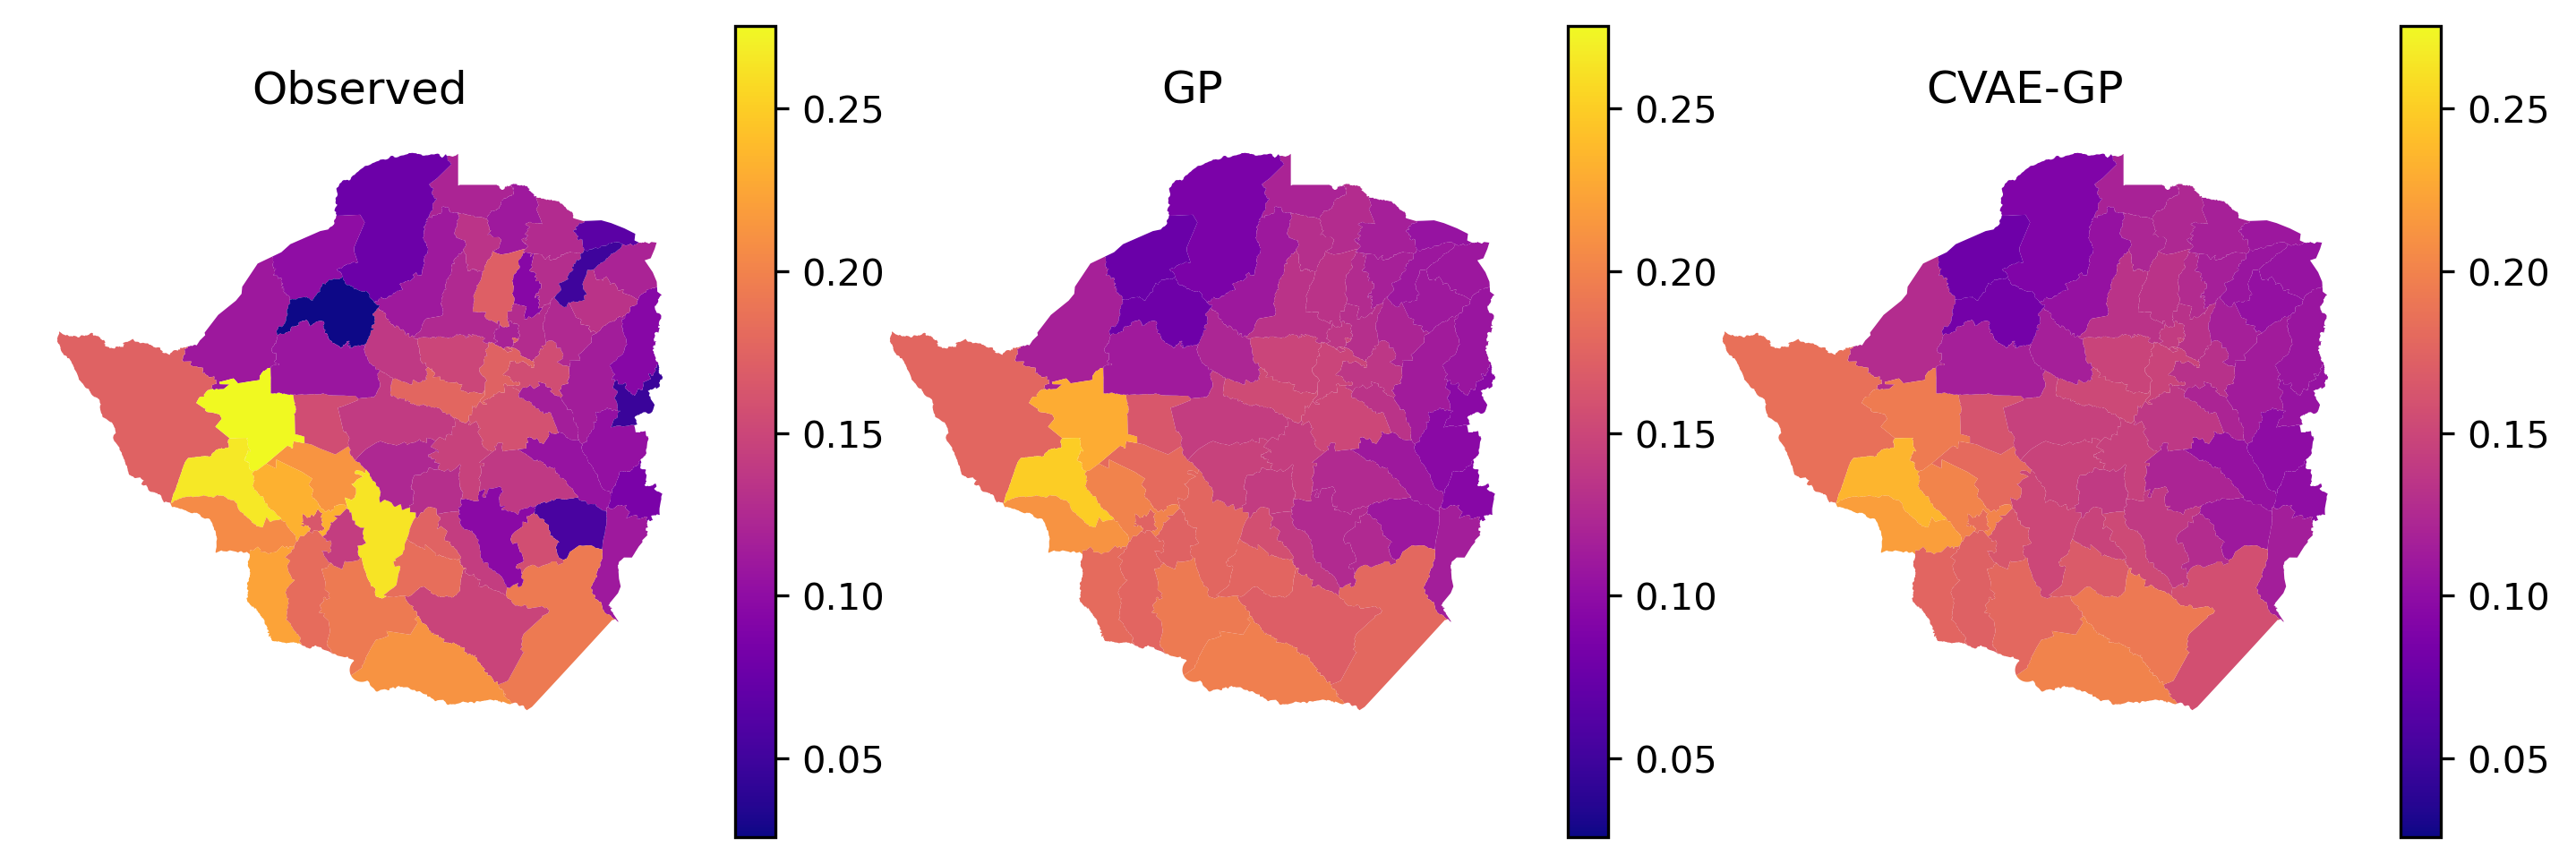

In [175]:
var = ['estimate', 'theta_gp', 'theta_vae']
ttls = ['Observed', 'GP', 'CVAE-GP']

_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae']])

fig, axs = plt.subplots(1, len(var), figsize=(12, 4))

for i in range(len(var)):
    s.plot(column=var[i], ax=axs[i], legend=True, cmap='plasma', vmin=_min, vmax =_max)
    #df.plot(column=var[i], ax=axs[i])
    axs[i].axis('off')
    axs[i].set_title(ttls[i])

fig.subplots_adjust(wspace=0, hspace=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/Zimbabwe_maps.pdf')


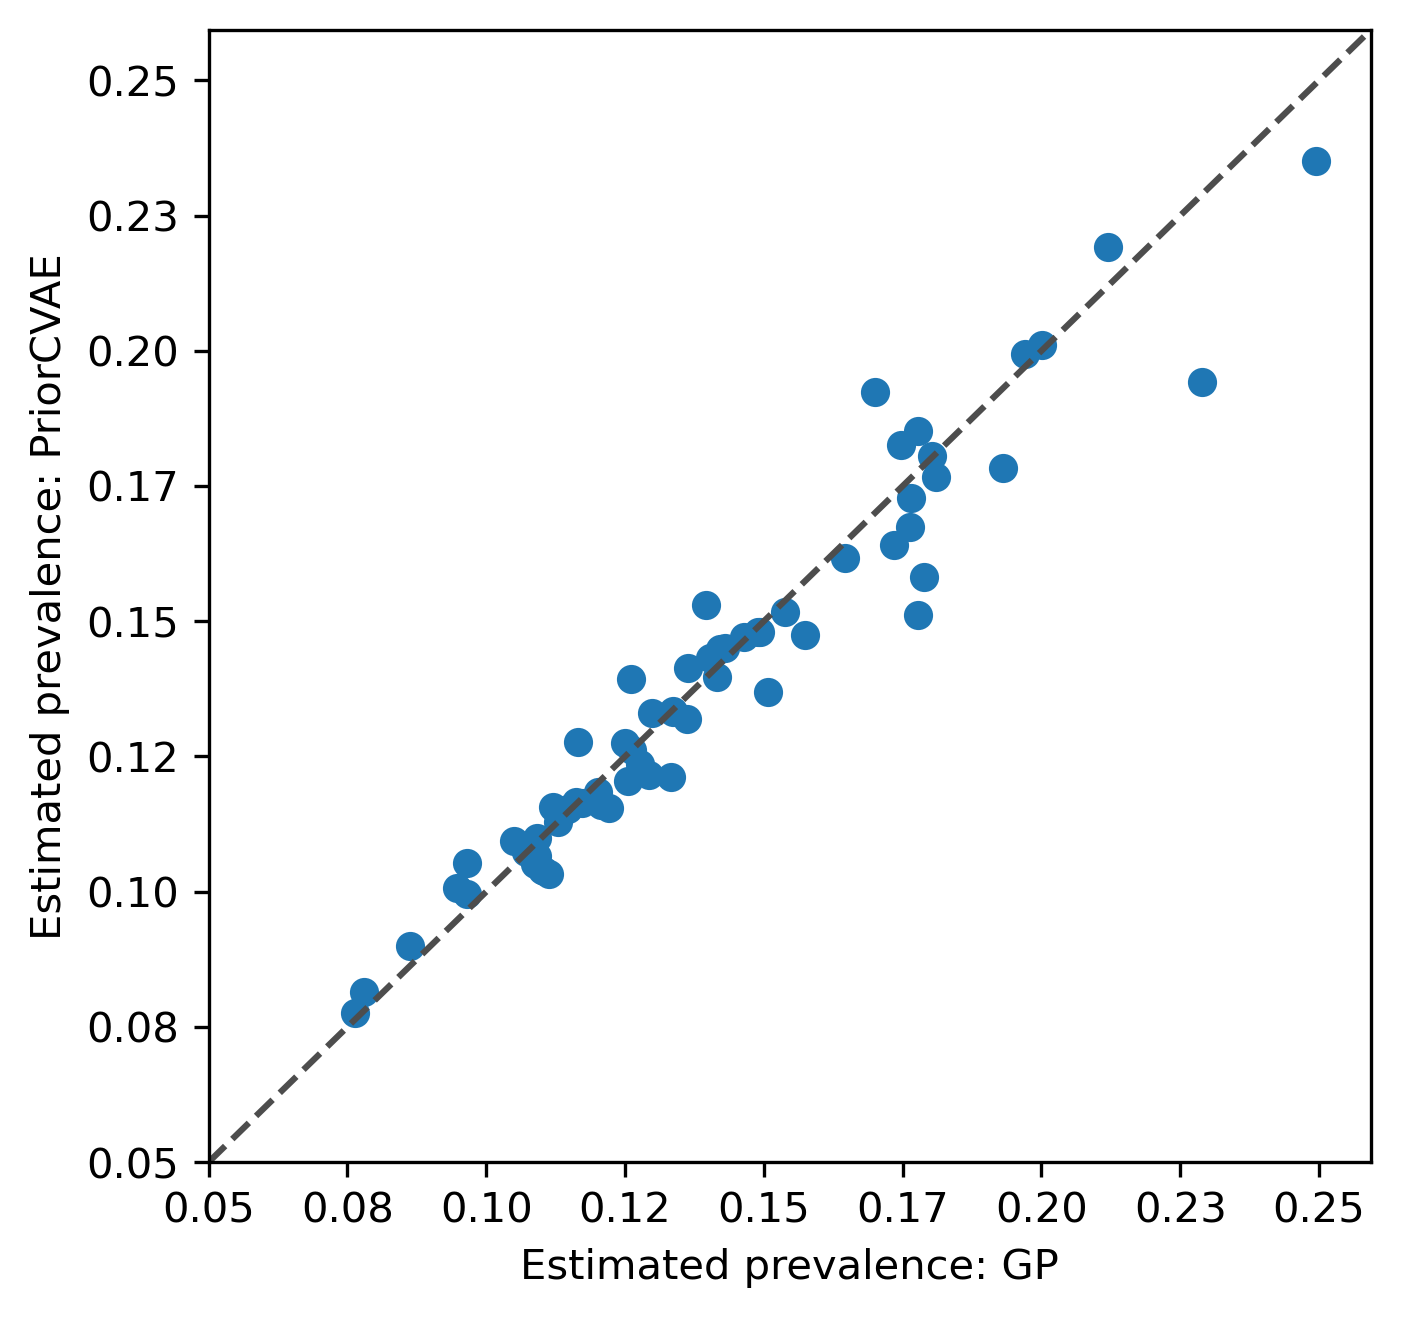

In [184]:
_max = np.max([ s['theta_gp'], s['theta_vae']])
_min = np.min([ s['theta_gp'], s['theta_vae']])

plt.rcParams["figure.figsize"] = (5,5)
from matplotlib.ticker import FormatStrFormatter


fig, ax = plt.subplots()

plt.scatter(s['theta_gp'], s['theta_vae'])
#plt.ylim(_min-0.01, _max+0.01)
plt.ylim(0.05, _max+0.01)
#plt.xlim(_min-0.01, _max+0.01)
plt.xlim(0.05, _max+0.01)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("Estimated prevalence: GP")
plt.ylabel("Estimated prevalence: PriorCVAE")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/Zimbabwe_estimates_prev.pdf')

Text(0, 0.5, 'observed theta')

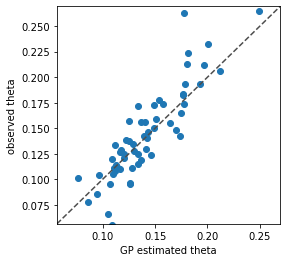

In [91]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_gp'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("GP estimated theta")
plt.ylabel("observed theta")

Text(0, 0.5, 'observed theta')

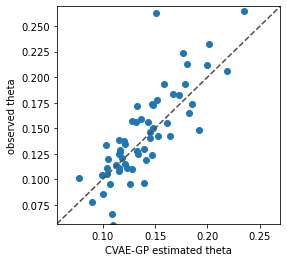

In [92]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_vae'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("CVAE-GP estimated theta")
plt.ylabel("observed theta")

In [93]:
_max = np.max([ theta_vae_car, theta_mean_car, bci_car_25, bci_car_75, bci_vae_car_25, bci_vae_car_75])
_min = np.min([ theta_mean_vae_car, theta_mean_car])

plt.rcParams["figure.figsize"] = (6,6)

plt.ylim(_min, _max)
plt.xlim(_min, _max)
plt.plot([_min, _max], [_min, _max], ls="--", c=".3")
plt.xlabel("predicted prevalence, VAE-CAR")
plt.ylabel("predicted prevalence, CAR")

plt.vlines(x=theta_mean_car, 
           ymin=bci_car_25,
           ymax=bci_car_75,
           color="orange", 
           label="50% BCI, CAR", 
           linewidth=0.8)
plt.hlines(y=theta_mean_vae_car, 
           xmin=bci_vae_car_25,
           xmax=bci_vae_car_75,
           color="steelblue", 
           label="50% BCI, VAE-CAR", 
           linewidth=0.8)

plt.scatter(theta_mean_vae_car, theta_mean_car, color="teal")
plt.legend(loc="upper left")

NameError: name 'theta_vae_car' is not defined